In [1]:
# inspired by https://www.kaggle.com/code/dbdmobile/predict-stocks-using-lstm 

# Importing all necessary libraries
import numpy as np
import pandas as pd
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import keras
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore") 

In [2]:
# method for saving the MinMaxScaler
def save_scaler(scaler, name):
    path = f"helper/{name}.joblib"
    joblib.dump(scaler, open(path, "wb"))

# method for loading the scaler
def load_scaler(name):
    path = f"helper/{name}.joblib"
    with open(path, 'rb') as file:
        scaler = joblib.load(file)
        return scaler

# method for saving the model
def save_model(model):
    path = "helper/model.h5"
    model.save(path, overwrite=True)

In [3]:
# Reading dataset from local library (data is not added to git)
ticker = "JPM"

RUN_NAME = f'{ticker} lstm prediction'

df = pd.read_csv(f'data/stocks/{ticker}.csv', parse_dates=['Date'])

# Calculating daily differences
df["Difference"] = df["Close"].diff()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,1980-03-17,0.0,5.129630,5.018518,5.037037,0.293599,62400,NaN
1,1980-03-18,0.0,5.111111,5.037037,5.074074,0.295758,63900,0.037037
2,1980-03-19,0.0,5.166667,5.111111,5.148148,0.300075,40500,0.074074
3,1980-03-20,0.0,5.148148,5.092593,5.111111,0.297916,18900,-0.037037
4,1980-03-21,0.0,5.222222,5.111111,5.222222,0.304393,97200,0.111111


In [4]:
# Defining a function that will contain data in a specific date range
def specific_data(company, df, start = dt.datetime(1990,1,1), end = dt.datetime(2024,1,1)):
    date_filtered_data = df[(df['Date'] > start) & (df['Date'] < end)]
    return date_filtered_data

df = specific_data(ticker, df)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
2476,1990-01-02,9.958333,10.041667,9.958333,10.000000,1.736889,1180500,0.041667
2477,1990-01-03,10.125000,10.333333,10.000000,10.333333,1.794786,1597200,0.333333
2478,1990-01-04,10.333333,10.416667,10.291667,10.375000,1.802022,1010100,0.041667
2479,1990-01-05,10.416667,10.416667,10.250000,10.416667,1.809260,936900,0.041667
2480,1990-01-08,10.375000,10.458333,10.291667,10.416667,1.809260,569400,0.000000


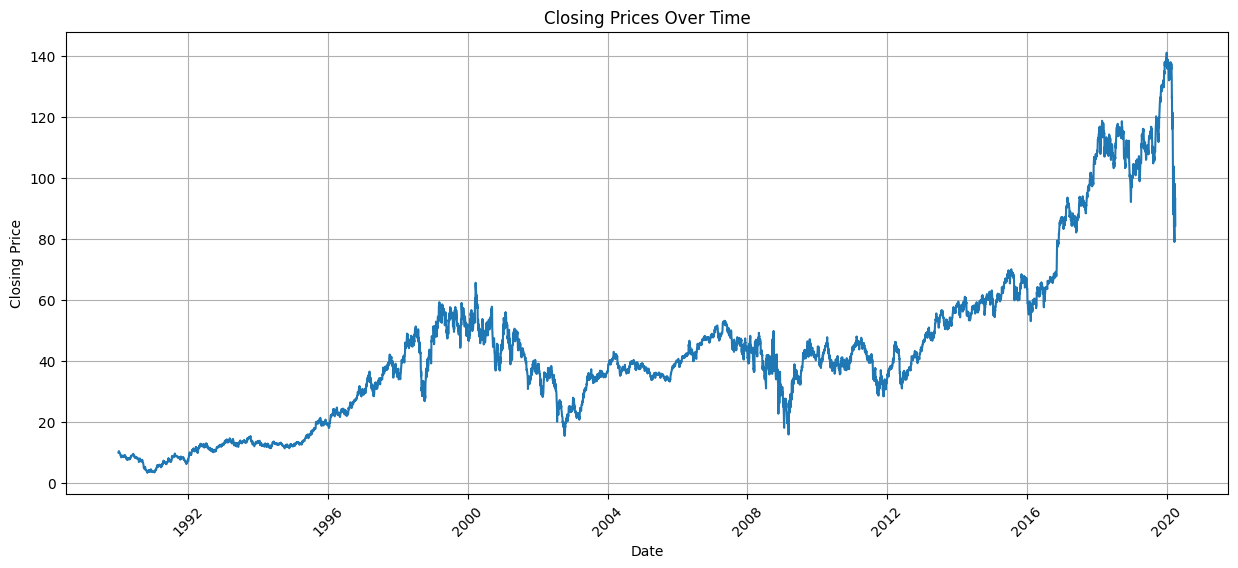

In [5]:
# Convert 'Date' column to datetime and printing out the loaded data to a plot
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

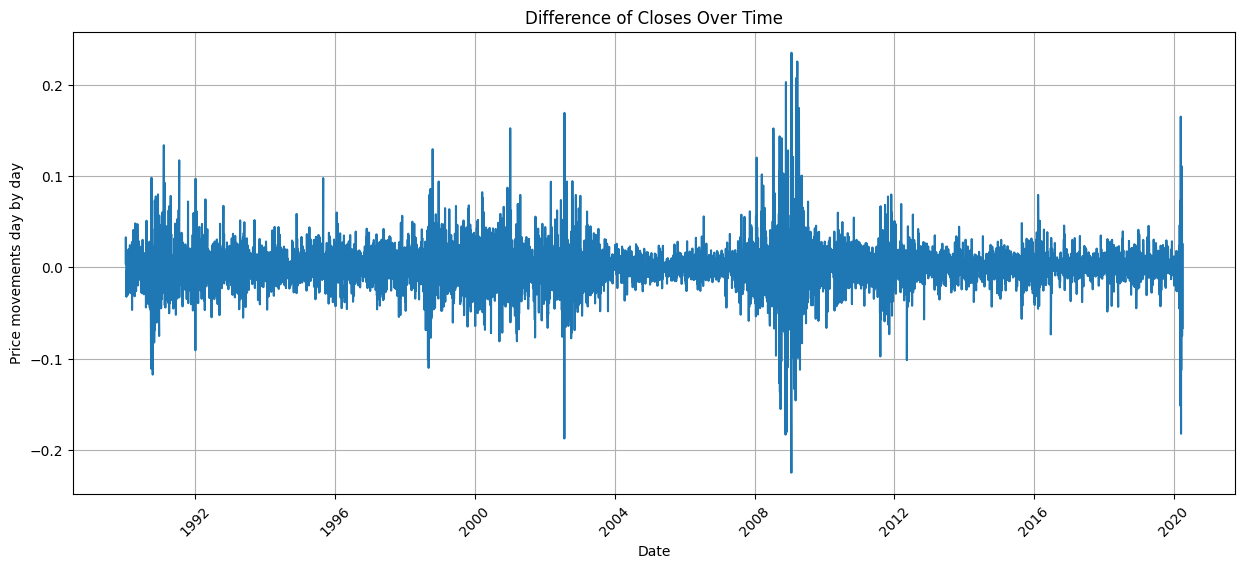

In [6]:
# Daily movement ratio to opening

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df["Difference"] / df["Open"])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

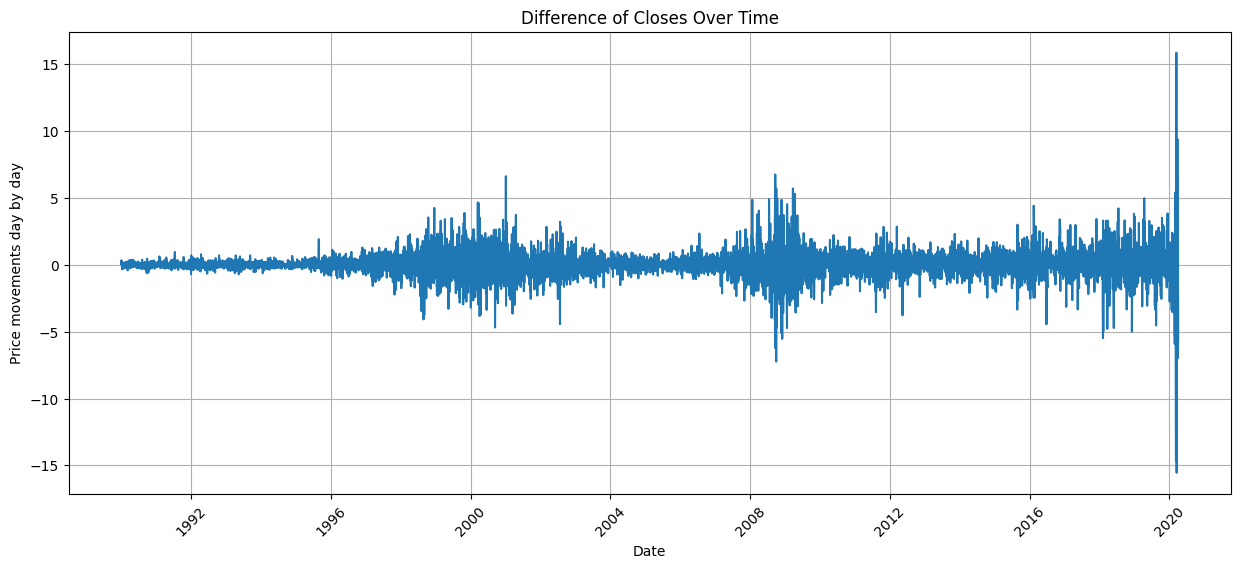

In [7]:
# daily movements in dollars

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Difference'])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [44]:
# Splitting data to training and test sets
# Scaling training and testing data, then saving scalers

scaler = MinMaxScaler()
close_scaler = MinMaxScaler()
without_date = df.drop( "Date", axis="columns")

df_train, df_test = train_test_split(without_date, test_size=0.2, shuffle=False)

scaled_train = scaler.fit_transform(df_train.values)
scaled_test = scaler.transform(df_test.values)
close_scaler.fit(np.array(df_train["Close"].values).reshape(-1,1))

save_scaler(close_scaler, "close_scaler")
save_scaler(scaler, "scaler")

print(scaled_train.shape)
print(scaled_test.shape)

(6097, 7)
(1525, 7)


In [45]:
# Defining a window to look into the past, and creating actual training and testing sets with that sliding window

past = 14

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(past, len(scaled_train)):
    X_train.append(scaled_train[i - past:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(past, len(scaled_test)):
    X_test.append(scaled_test[i - past:i])
    y_test.append(scaled_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(6083, 14, 7)
(6083, 7)
Testing set size:-
(1511, 14, 7)
(1511, 7)


(None, None)

In [46]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 64 units, input shape, and return sequences
model.add(LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 64 units and return sequences
model.add(LSTM(units=64, activation="relu", return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 64 units
model.add(LSTM(units=64, activation="relu"))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(1))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 14, 64)            18432     
                                                                 
 dropout_3 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 14, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [47]:
# Compiling model, defining loss function and optimizer, which determines learing rate

model.compile(loss='mse',optimizer='adam')

In [56]:
# Fitting the model

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
logger = keras.callbacks.TensorBoard(
        log_dir=f"logs/{RUN_NAME}",
        write_graph=True,
        histogram_freq=64
)

# Training our lstm model
model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=50,
          batch_size=64,
          verbose=1,
          callbacks= [early_stopping, logger])

save_model(model)

Epoch 1/50
77/77 [==============================] - 2s 29ms/step - loss: 0.0342 - val_loss: 0.0391
Epoch 2/50
77/77 [==============================] - 2s 28ms/step - loss: 0.0341 - val_loss: 0.0368
Epoch 3/50
77/77 [==============================] - 2s 26ms/step - loss: 0.0340 - val_loss: 0.0392
Epoch 4/50
77/77 [==============================] - 3s 37ms/step - loss: 0.0340 - val_loss: 0.0364
Epoch 5/50
77/77 [==============================] - 4s 51ms/step - loss: 0.0340 - val_loss: 0.0364
Epoch 6/50
77/77 [==============================] - 3s 37ms/step - loss: 0.0340 - val_loss: 0.0379
Epoch 7/50
77/77 [==============================] - 3s 35ms/step - loss: 0.0340 - val_loss: 0.0395
Epoch 8/50
77/77 [==============================] - 3s 36ms/step - loss: 0.0340 - val_loss: 0.0395
Epoch 9/50
77/77 [==============================] - 3s 36ms/step - loss: 0.0339 - val_loss: 0.0360
Epoch 10/50
77/77 [==============================] - 3s 34ms/step - loss: 0.0339 - val_loss: 0.0367
Epoch 11/

In [57]:
# predict and check performance metrics

train_predict=model.predict(X_train, verbose=0)
test_predict=model.predict(X_test, verbose=0)

In [58]:
# Transform back to original form

loaded_scaler = load_scaler("close_scaler")

test_predict = loaded_scaler.inverse_transform(test_predict)
train_predict = loaded_scaler.inverse_transform(train_predict)

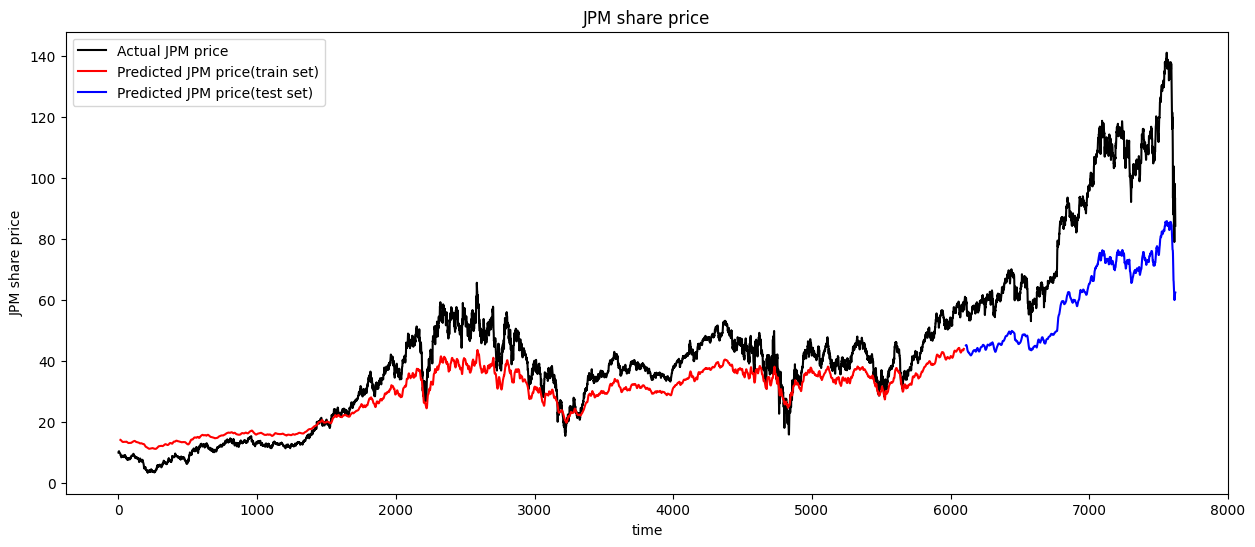

In [59]:
# Set the number of previous time steps to consider for plotting
look_back = past

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(df["Close"])
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(df["Close"])
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = np.array(df["Close"])

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {ticker} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {ticker} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {ticker} price(test set)")

plt.title(f"{ticker} share price")
plt.xlabel("time")
plt.ylabel(f"{ticker} share price")
plt.legend()
plt.show()

In [60]:
print(original_scaled_data.shape)
predicted = pd.concat([pd.DataFrame(train_predict), pd.DataFrame(test_predict)])
print(predicted)

(7622,)
              0
0     14.138559
1     14.121785
2     14.102120
3     14.064631
4     14.022658
...         ...
1506  60.775024
1507  61.754715
1508  62.114746
1509  62.346935
1510  62.453373

[7594 rows x 1 columns]


In [61]:
# Concatenate training and testing data to see how efficient it predicted

concatenated = pd.concat([df_train["Close"][look_back:], df_test["Close"][look_back:]])

combined = pd.concat(
[
    predicted, 
    pd.DataFrame(
        concatenated
    ).set_index(predicted.index)
], 
    axis=1, 
    ignore_index=False
)
combined.columns = ["Predicted", "Close"]
combined["Difference"] = combined["Close"].diff()
combined["Predicted difference"] = combined["Predicted"].diff()
combined["Same Direction"] = combined.apply(lambda x: x["Predicted difference"] * x["Difference"] > 0, axis=1)
print(combined)

      Predicted      Close  Difference  Predicted difference  Same Direction
0     14.138559   9.333333         NaN                   NaN           False
1     14.121785   9.083333   -0.250000             -0.016774            True
2     14.102120   9.125000    0.041667             -0.019665           False
3     14.064631   9.041667   -0.083333             -0.037489            True
4     14.022658   8.833333   -0.208334             -0.041973            True
...         ...        ...         ...                   ...             ...
1506  60.775024  98.120003    6.389999              0.405678            True
1507  61.754715  91.129997   -6.990005              0.979691           False
1508  62.114746  93.500000    2.370003              0.360031            True
1509  62.346935  90.029999   -3.470001              0.232189           False
1510  62.453373  84.360001   -5.669998              0.106438           False

[7594 rows x 5 columns]


In [62]:
import collections
counter = collections.Counter(combined["Same Direction"])
print(counter)

Counter({False: 3997, True: 3597})


In [63]:
# predicting right direction for the stock to move

counter[True] / (counter[False] + counter[True])

0.4736634184882802